task2 
setup

In [163]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import KFold
mpl.rcParams['figure.dpi']= 300 
import itertools

In [164]:
torch.manual_seed(42)
np.random.seed(42)

In [165]:
data_sobol = pd.read_csv("samples_sobol.txt", sep =" ", header = None)


In [166]:
print(data_sobol)

             0         1         2         3         4         5         6  \
0     0.500000  0.500000  0.500000  0.500000  0.500000  0.500000  0.500000   
1     0.750000  0.250000  0.750000  0.250000  0.750000  0.250000  0.750000   
2     0.250000  0.750000  0.250000  0.750000  0.250000  0.750000  0.250000   
3     0.375000  0.375000  0.625000  0.125000  0.875000  0.875000  0.125000   
4     0.875000  0.875000  0.125000  0.625000  0.375000  0.375000  0.625000   
...        ...       ...       ...       ...       ...       ...       ...   
2555  0.252686  0.065674  0.194580  0.487549  0.293213  0.955811  0.739502   
2556  0.752686  0.565674  0.694580  0.987549  0.793213  0.455811  0.239502   
2557  0.502686  0.315674  0.944580  0.237549  0.543213  0.705811  0.489502   
2558  0.002686  0.815674  0.444580  0.737549  0.043213  0.205811  0.989502   
2559  0.003662  0.062744  0.771729  0.256104  0.714111  0.892334  0.062744   

             7  
0     0.500000  
1     0.250000  
2     0.7500

In [167]:
type(data_sobol)

pandas.core.frame.DataFrame

In [168]:
print(data_sobol.shape)

(2560, 8)


In [169]:
data_sobol = data_sobol.iloc[:160,:]

opt_type = "LBFGS"
data_training_1601 = pd.read_csv('TrainingData_1601.txt',sep=' ', header = None)
data_training_1601 = pd.DataFrame(data_training_1601)

data_training_1601.shape[0]
validation_size = int(30*data_training_1601.shape[0]/100)
training_size = data_training_1601.shape[0] - validation_size


In [170]:
print(data_sobol.shape)
print(data_training_1601.shape)

(160, 8)
(160, 9)


In [179]:
x = data_sobol.iloc[:,:]
y = data_training_1601.iloc[:,8]

x_train = data_sobol.iloc[:training_size,:]
y_train = data_training_1601.iloc[:training_size,8]

x_val = data_sobol.iloc[training_size:,:]
y_val = data_training_1601.iloc[training_size:,8]

x_train = torch.from_numpy(x_train.values).float()
y_train = torch.from_numpy(y_train.values).float()

x = torch.from_numpy(x.values.reshape(-1,8)).float()
y = torch.from_numpy(y.values.reshape(-1,1)).float()

batch_size = 5
training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size= batch_size, shuffle = True)

In [180]:
type(x_train)


torch.Tensor

In [181]:
type(x_val)

pandas.core.frame.DataFrame

In [182]:
x_val = torch.from_numpy(x_val.values).float()
y_val = torch.from_numpy(y_val.values).float()

In [183]:
type(x_val)


torch.Tensor

model generation

In [184]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        
        # Random Seed for weight initialization
        self.retrain = 128
        # Xavier weight initialization
        self.init_xavier()

        if self.n_hidden_layers != 0:
            self.input_layer = nn.Linear(self.input_dimension, self.neurons)
            self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers-1)])
            self.output_layer = nn.Linear(self.neurons, self.output_dimension)
        else:
            print("Simple linear regression")
            self.linear_regression_layer = nn.Linear(self.input_dimension, self.output_dimension)
            
    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        if self.n_hidden_layers != 0:
            x = self.activation(self.input_layer(x))
            for k, l in enumerate(self.hidden_layers):
                x = self.activation(l(x))
            return self.output_layer(x)
        else:
            return self.linear_regression_layer(x)
    
    def init_xavier(self):
        torch.manual_seed(self.retrain)
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                #torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)
        self.apply(init_weights)

In [187]:
def run_single_configuration(conf_dict, x_, y_):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    print(conf_dict)

    # Get the configuration to test
    opt_type = conf_dict["optimizer"]
    n_epochs = conf_dict["epochs"]
    n_hidden_layers = conf_dict["hidden_layers"]
    neurons = conf_dict["neurons"]
    regularization_param = conf_dict["regularization_param"]
    regularization_exp = conf_dict["regularization_exp"]
    retrain_seed = conf_dict["init_weight_seed"]
    batch_size = conf_dict["batch_size"]
    activation = conf_dict["activation"]

    validation_size = int(20 * x_.shape[0] / 100)
    training_size = x_.shape[0] - validation_size
    x_train = x_[:training_size, :]
    y_train = y_[:training_size, :]

    x_val = x_[training_size:, :]
    y_val = y_[training_size:, :]

    training_set = DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

    my_network = NeuralNet(input_dimension=x_.shape[1],
                           output_dimension=y_.shape[1],
                           n_hidden_layers=n_hidden_layers,
                           neurons=neurons,
                           regularization_param=regularization_param,
                           regularization_exp=regularization_exp,
                           retrain_seed=retrain_seed,
                           activation_name=activation)

    if opt_type == "ADAM":
        optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
    elif opt_type == "LBFGS":
        optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
    else:
        raise ValueError("Optimizer not recognized")

    history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose=False)

    y_val = y_val.reshape(-1, )
    y_train = y_train.reshape(-1, )

    y_train_pred = my_network(x_train).reshape(-1,)
    y_val_pred = my_network(x_val).reshape(-1,)
    
    relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
    print('Relative Training Error:', relative_error_train.detach().numpy() ** 0.5 * 100, '%')
    
    relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
    print('Relative Validation Error:', relative_error_val.detach().numpy() ** 0.5 * 100, '%')
    
    plt.figure(figsize=(16, 8))
    plt.grid(True, which="both", ls=":")
    plt.plot(np.arange(1,n_epochs+1), history[0], label="Training Loss")
    plt.plot(np.arange(1,n_epochs+1), history[1], label="Validation Loss")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
#     plt.figure(figsize=(16, 8))
#     plt.grid(True, which="both", ls=":")
#     plt.scatter(x_train[:,0], y_train, label="Training Data", marker="o", color="C0")
#     plt.scatter(x_val[:,0], y_val, label="Validation Data", marker="*", color="C1", s=100)
#     plt.scatter(x_test[:,0], y_test_pred.detach(), label="Network Prediction",lw=2, color="black", ls="-.")
#     plt.xlabel("x")
#     plt.ylabel("u")
#     plt.legend()
#     plt.show()

In [188]:
n_samples = x.shape[0]
hyperparameters_configurations = {
    "epochs": [10],
    "hidden_layers": [2],
    "neurons": [16],
    "regularization_exp": [2],
    "regularization_param": [0],
    "batch_size": [n_samples],
    "optimizer": ["LBFGS"],
    "init_weight_seed": [10, 20, 567, 34, 134],
    "activation": ["tanh"]
}

settings = list(itertools.product(*hyperparameters_configurations.values()))

for set_num, setup in enumerate(settings):
    print('####################', set_num, '####################')
    setup_properties = {
        'epochs': setup[0],
        'hidden_layers': setup[1],
        'neurons': setup[2],
        'regularization_exp': setup[3],
        'regularization_param': setup[4],
        'batch_size': setup[5],
        'optimizer': setup[6],
        'init_weight_seed': setup[7],
        'activation': setup[8]
    }
    
    run_single_configuration(setup_properties, x, y)

#################### 0 ####################
{'epochs': 10, 'hidden_layers': 2, 'neurons': 16, 'regularization_exp': 2, 'regularization_param': 0, 'batch_size': 160, 'optimizer': 'LBFGS', 'init_weight_seed': 10, 'activation': 'tanh'}


TypeError: __init__() got an unexpected keyword argument 'regularization_param'

model definition 

In [156]:
my_network = NeuralNet(input_dimension=8, output_dimension=1, n_hidden_layers=4, neurons=20) 

model training 

In [157]:

if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.0001, weight_decay=0)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [158]:
def fit(model, training_set, x_validation_, y_validation_, num_epochs, optimizer, p, verbose=True):
    history = [[], []]
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                u_pred_ = model(x_train_)
                # Item 1. below
                loss = torch.mean(abs(u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()/ len(training_set)
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        y_validation_pred_ = model(x_validation_)
        validation_loss = torch.mean((y_validation_pred_.reshape(-1, ) - y_validation_.reshape(-1, ))**p).item()
        history[0].append(running_loss[0])
        history[1].append(validation_loss)
        
        if verbose:
            print('Training Loss: ', np.round(running_loss[0],8))
            print('Validation Loss: ', np.round(validation_loss,8))


    print('Final Training Loss: ', np.round(history[0][-1],8))
    print('Final Validation Loss: ', np.round(history[1][-1],8))
    return history


In [159]:
type(y_train)

torch.Tensor

In [161]:
n_epochs= 500
history = fit(my_network, training_set, x_val, y_val, n_epochs, optimizer_, p=2, verbose = False)
y_val = y_val.reshape(-1, )
y_train = y_train.reshape(-1, )

y_val_pred = my_network(x_val).reshape(-1, )
y_train_pred = my_network(x_train).reshape(-1, )

# Compute the relative validation error
relative_error_train = torch.mean((y_train_pred - y_train) ** 2) / torch.mean(y_train ** 2)
print("Relative Training Error: ", relative_error_train.detach().numpy() ** 0.5 * 100, "%")

# Compute the relative validation error
relative_error_val = torch.mean((y_val_pred - y_val) ** 2) / torch.mean(y_val ** 2)
print("Relative Validation Error: ", relative_error_val.detach().numpy() ** 0.5 * 100, "%")


Final Training Loss:  0.0180524
Final Validation Loss:  0.01744827
Relative Training Error:  32.11228847503662 %
Relative Validation Error:  31.294503808021545 %


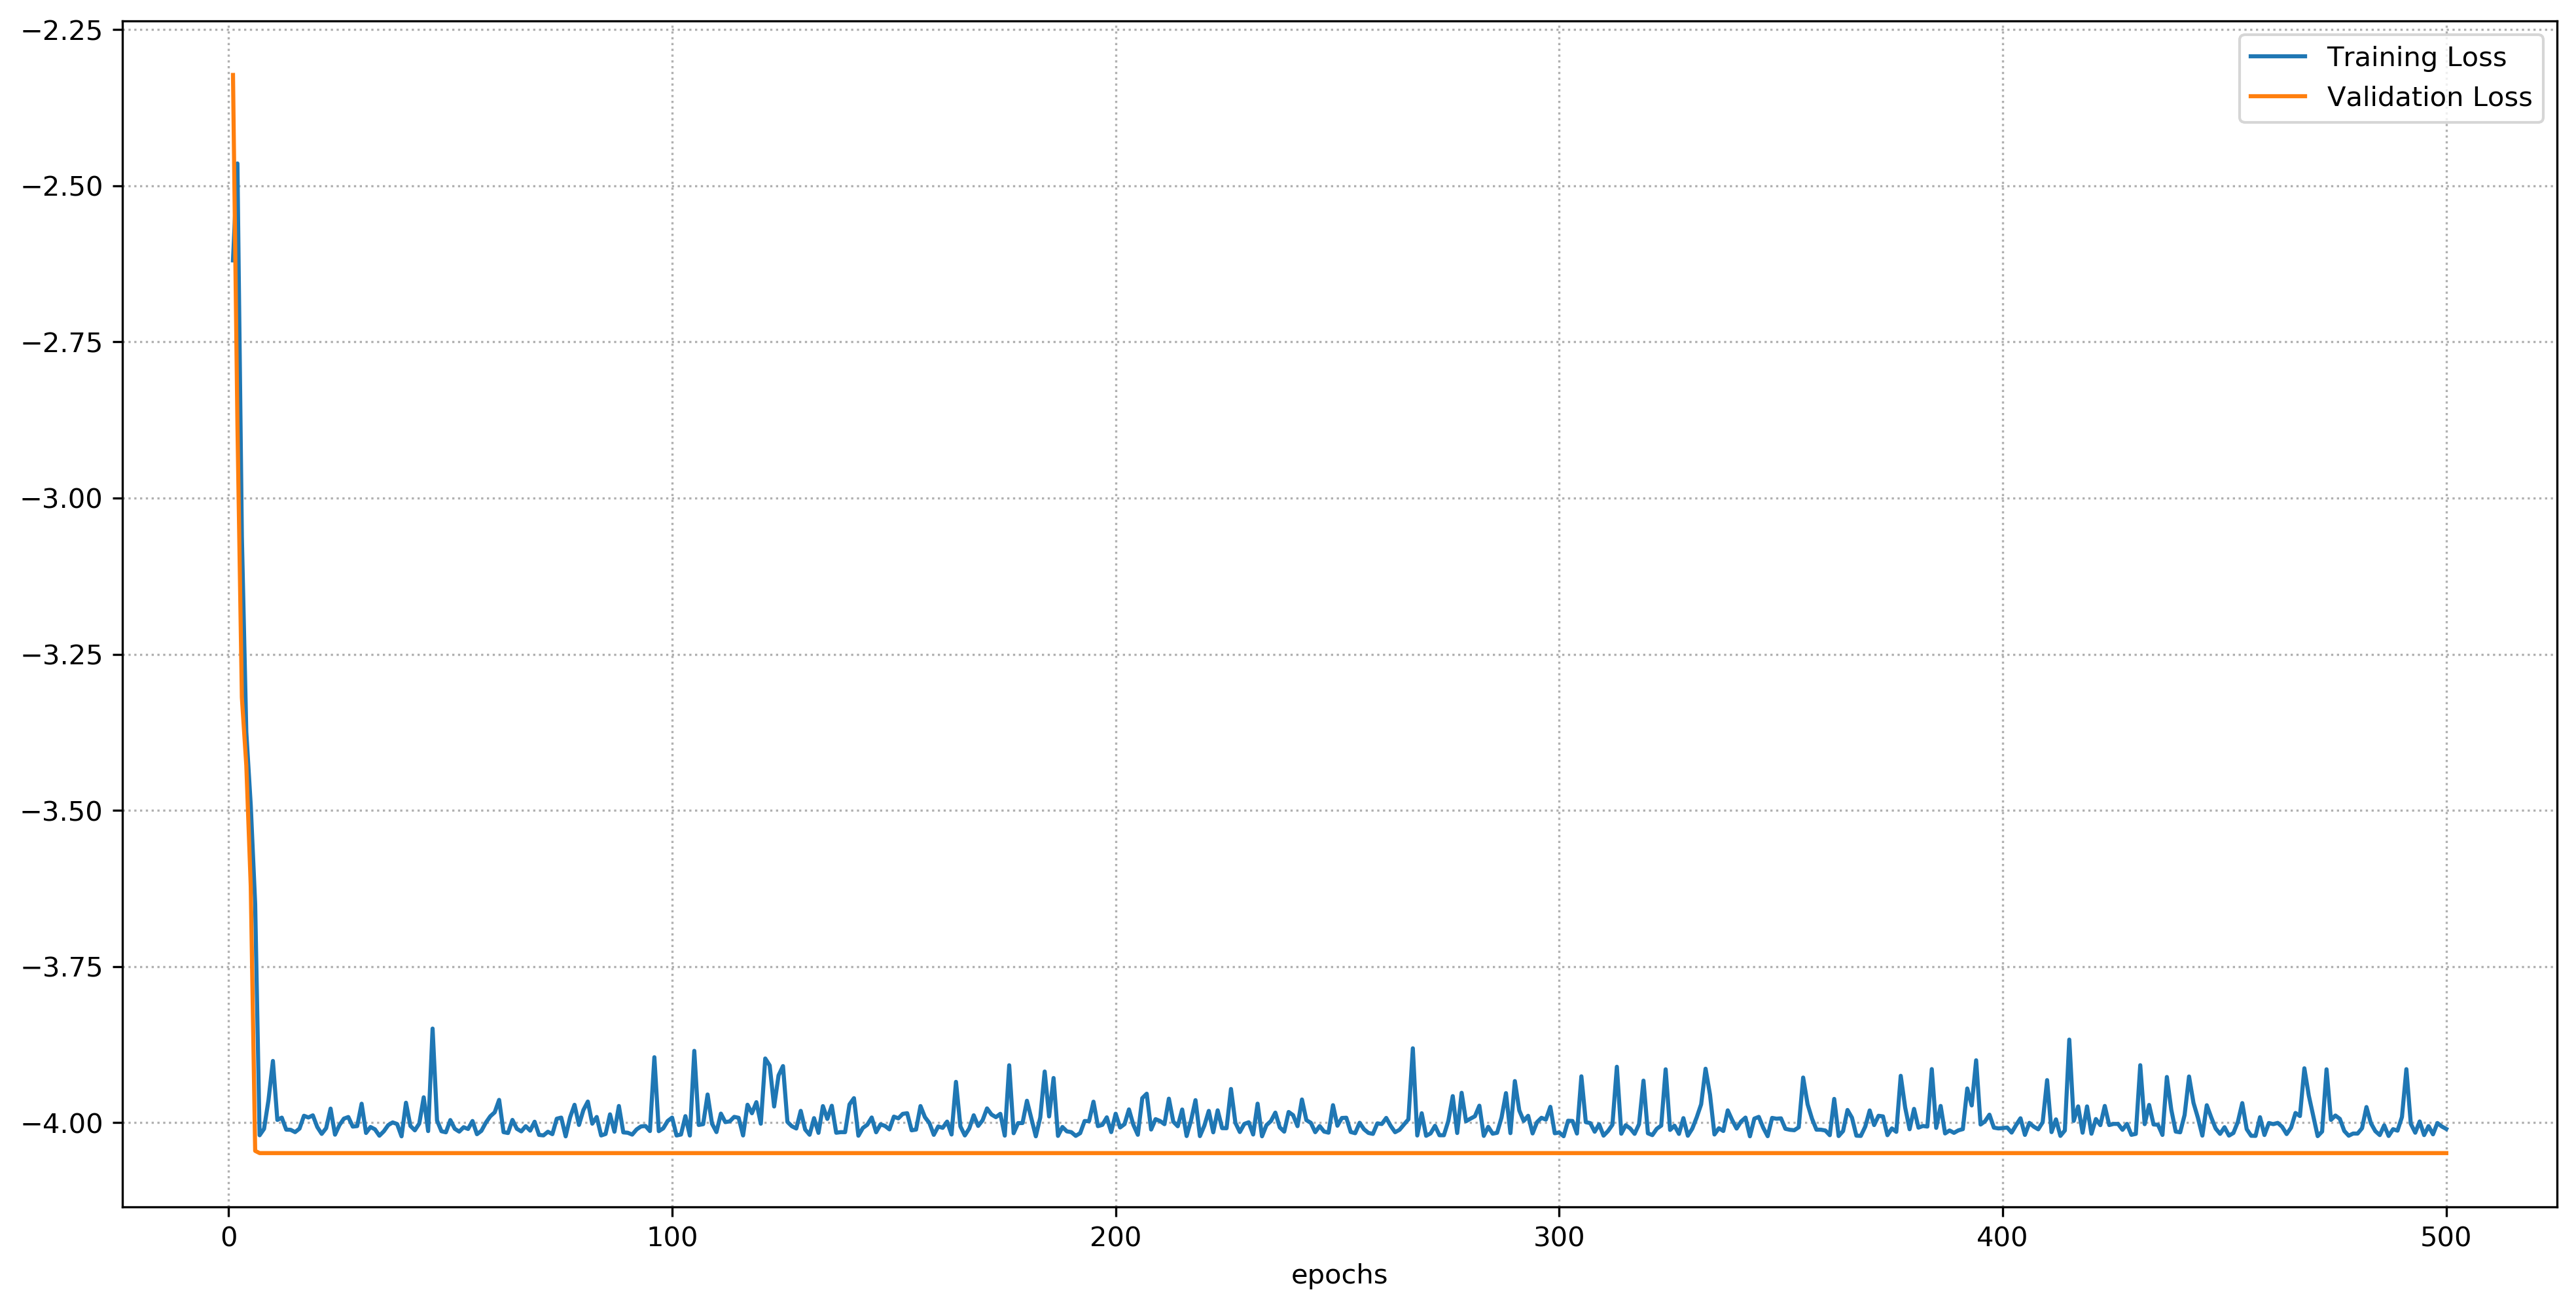

In [130]:
plt.figure(figsize=(16,8))
plt.grid(True, which = "both", ls=":")
plt.plot(np.arange(1, n_epochs+1), np.log(history[0]), label="Training Loss")
plt.plot(np.arange(1, n_epochs+1), np.log(history[1]), label="Validation Loss")
#plt.xscale("log")
#plt.yscale("log")
plt.xlabel("epochs")
plt.legend()

In [76]:
data_testing = pd.read_csv('TestingData.txt',sep=' ')
data_testing= pd.DataFrame(data_testing)

In [77]:
type(data_testing)

pandas.core.frame.DataFrame

In [78]:
print(data_testing.shape)

(1999, 8)


In [81]:
data_testing=torch.from_numpy(data_testing.values).float()

In [82]:
y_test_pred = my_network(data_testing)

In [83]:
print(y_test_pred)

tensor([[0.4997],
        [0.5000],
        [0.5314],
        ...,
        [0.3667],
        [0.5329],
        [0.4176]], grad_fn=<AddmmBackward0>)


In [84]:
print(y_test_pred.shape)

torch.Size([1999, 1])
